In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -r "/content/drive/My Drive/dataset/requirements.txt"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from collections import Counter

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

In [5]:
file_path = "/content/drive/My Drive/dataset/eng-french.csv"
df = pd.read_csv(file_path)
print(df.head())

  English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !


In [6]:
df.shape

(175621, 2)

In [7]:
# Separating the English and French datasets
eng = df['English words/sentences']
fra = df['French words/sentences']

In [8]:
eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print("Total count of English words:",len([word for sentence in eng for word in sentence.split()]))
print("Count of distinct English words:",len(eng_word_counter))
print("10 most common English words:",list(zip(*eng_word_counter.most_common(10)))[0])

Total count of English words: 1082098
Count of distinct English words: 27393
10 most common English words: ('I', 'to', 'you', 'the', 'a', 'is', 'Tom', 'of', 'in', 'have')


In [9]:
fra_word_counter = Counter([word for sentence in fra for word in sentence.split()])
print("Total count of French words:",len([word for sentence in fra for word in sentence.split()]))
print("Count of distinct French words:",len(fra_word_counter))
print("10 most common French words:",list(zip(*fra_word_counter.most_common(10)))[0])

Total count of French words: 1177832
Count of distinct French words: 44918
10 most common French words: ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'la', 'le', 'Il')


In [10]:
from wordcloud import WordCloud

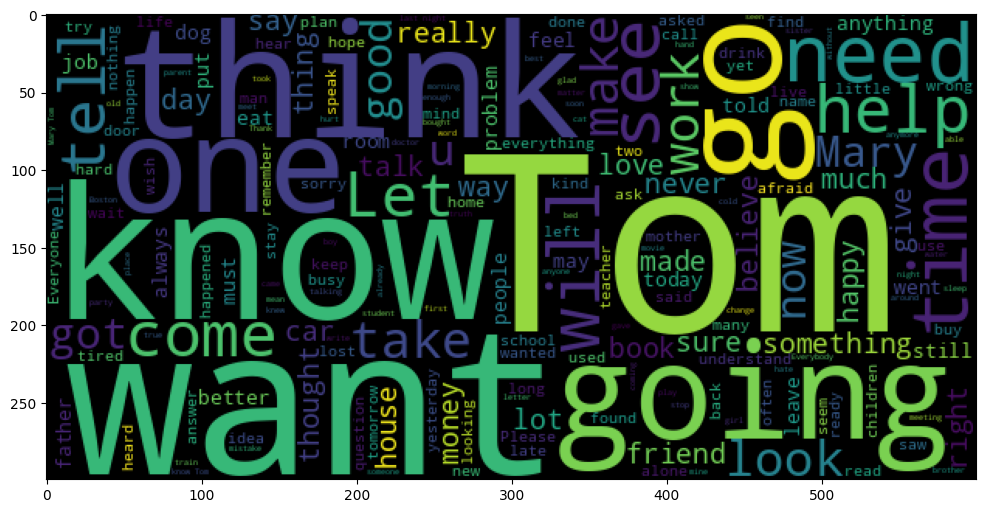

In [11]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(eng))
plt.imshow(wc)
plt.show();

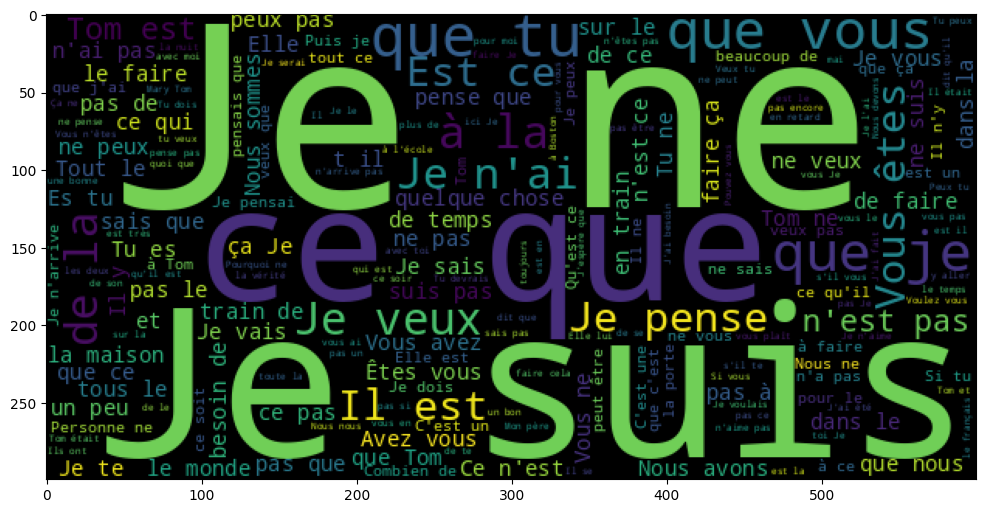

In [12]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(fra))
plt.imshow(wc)
plt.show();

In [13]:
def word_count(line):
  return len(line.split())

In [14]:
df['English_word_count'] = df['English words/sentences'].apply(lambda x: word_count(x))
df['French_word_count'] = df['French words/sentences'].apply(lambda x: word_count(x))

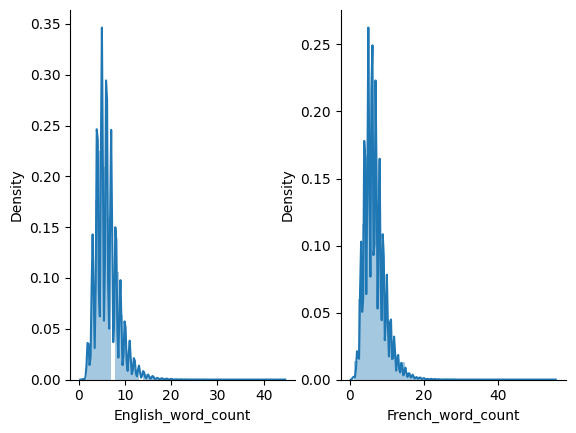

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2)
sns.distplot(df['English_word_count'],ax=axes[0])
sns.distplot(df['French_word_count'],ax=axes[1])
sns.despine()
plt.show();

In [16]:
def create_tokenizer(sentences):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sentences)
  return tokenizer

In [17]:
def max_sentence_length(lines):
  return max(len(sentence.split()) for sentence in lines)

In [18]:
def encode_sequences(tokenizer,sentences,max_sent_len):
  text_to_seq = tokenizer.texts_to_sequences(sentences) # encode sequences with integers
  text_pad_seq = pad_sequences(text_to_seq,maxlen=max_sent_len,padding='post') # pad sequences with 0
  return text_pad_seq

In [19]:
# Prepare English tokenizer
eng_tokenizer = create_tokenizer(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_sent_len = max_sentence_length(eng)
print("English vocabulary size:", eng_vocab_size)
print("Maximum length of English sentences:", max_eng_sent_len)

English vocabulary size: 14532
Maximum length of English sentences: 44


In [20]:
# Prepare French tokenizer
fra_tokenizer = create_tokenizer(fra)
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_fra_sent_len = max_sentence_length(fra)
print("French vocabulary size:", fra_vocab_size)
print("Maximum length of French sentences:", max_fra_sent_len)

French vocabulary size: 30661
Maximum length of French sentences: 55


In [21]:
max_eng_sent_len = 22
max_fra_sent_len = 22

In [22]:
# Perform encoding of sequences
X = encode_sequences(eng_tokenizer,eng,max_eng_sent_len)
y = encode_sequences(fra_tokenizer,fra,max_fra_sent_len)

In [23]:
y

array([[ 4241,     0,     0, ...,     0,     0,     0],
       [ 6947,     0,     0, ...,     0,     0,     0],
       [18607,     0,     0, ...,     0,     0,     0],
       ...,
       [   13,   962,    31, ..., 15477,   161,   180],
       [17089, 30659,     1, ...,     2,   291,  9637],
       [   37,   159,  1059, ...,    15,  2643,  2300]], dtype=int32)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=101)

In [25]:
(X_train.shape), (X_test.shape)

((149277, 22), (26344, 22))

In [26]:
def create_model(src_vocab_size,dest_vocab_size,src_timesteps,dest_timesteps,no_units):
  model = Sequential()
  model.add(Embedding(src_vocab_size,no_units,input_length=src_timesteps,mask_zero=True))
  model.add(LSTM(no_units))
  model.add(RepeatVector(dest_timesteps))
  model.add(LSTM(no_units,return_sequences=True))
  model.add(TimeDistributed(Dense(1024,activation='relu')))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(dest_vocab_size,activation='softmax')))
  return model

In [27]:
model = create_model(eng_vocab_size,fra_vocab_size,max_eng_sent_len,max_fra_sent_len,512)


In [28]:
model.build(input_shape=(None, max_eng_sent_len))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 22, 512)             │       7,440,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 22, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 22, 512)             │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 22, 1024)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 22, 30661)           │      31,427,525 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,591,621 (166.29 MB)

 Trainable params: 43,591,621 (166.29 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss=SparseCategoricalCrossentropy(),optimizer='rmsprop',metrics=['accuracy'])

In [30]:
es = EarlyStopping(monitor='val_accuracy',patience=3,mode='max',verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,mode='max',verbose=1,factor=0.1,min_lr=0.001)

In [31]:
r = model.fit(X_train,
              y_train.reshape(y_train.shape[0],y_train.shape[1],1),
              epochs=5,
              batch_size=512,
              callbacks=[es,lr],
              validation_data=(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1)))

Epoch 1/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.6857 - loss: 3.3360 - val_accuracy: 0.7091 - val_loss: 2.1378 - learning_rate: 0.0010
Epoch 2/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.7120 - loss: 2.1126 - val_accuracy: 0.7131 - val_loss: 2.0975 - learning_rate: 0.0010
Epoch 3/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.7162 - loss: 2.0395 - val_accuracy: 0.7187 - val_loss: 1.9804 - learning_rate: 0.0010
Epoch 4/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.7196 - loss: 1.9799 - val_accuracy: 0.7204 - val_loss: 1.9511 - learning_rate: 0.0010
Epoch 5/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7213 - loss: 1.9410 - val_accuracy: 0.7209 - val_loss: 1.9423 - learning_rate: 0.0010


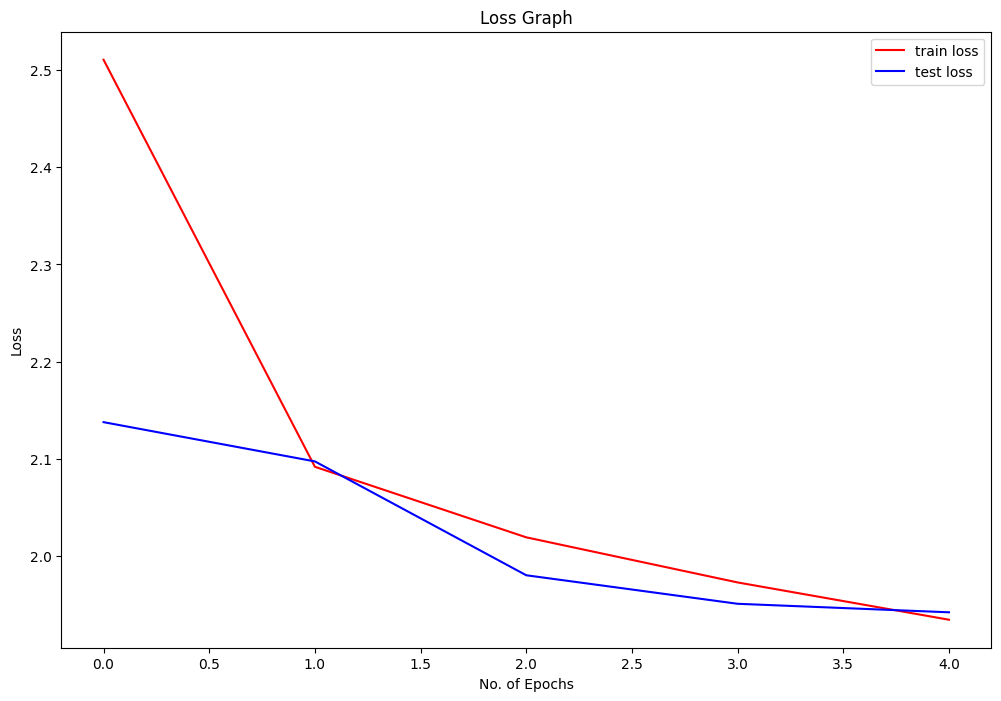

In [32]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

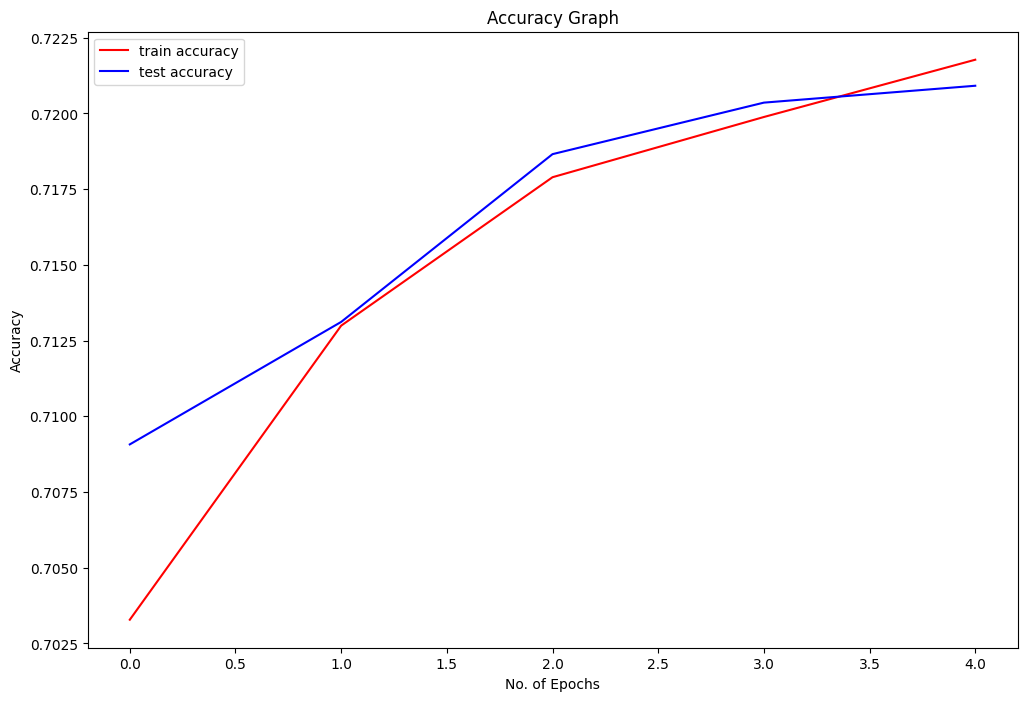

In [33]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [34]:
model.evaluate(X_test,y_test.reshape(y_test.shape[0],y_test.shape[1],1))

824/824 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.7204 - loss: 1.9451


[1.9423493146896362, 0.7209168672561646]

In [44]:
model.save('/content/drive/My Drive/dataset/english_to_french_translator.keras')

In [43]:
import os
print(os.listdir('/content/'))

['.config', 'drive', 'english_to_french_translator.h5', 'english_to_french_translator.keras', 'sample_data']


In [45]:
import os
print(os.path.exists('/content/drive/My Drive/dataset/english_to_french_translator.keras'))


True


In [46]:
import os
print(os.path.exists('/content/drive/My Drive/dataset'))  # Check if folder exists


True


In [47]:
translator_model = load_model('/content/drive/My Drive/dataset/english_to_french_translator.keras')
translator_model

<Sequential name=sequential, built=True>

In [48]:
print(translator_model.summary())  # Check model architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 22, 512)             │       7,440,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 22, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 22, 512)             │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 22, 1024)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 22, 30661)           │      31,427,525 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,183,244 (332.58 MB)

 Trainable params: 43,591,621 (166.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,591,623 (166.29 MB)

None


In [49]:
sample_test, orig_fra_sent = X_test[:22], y_test[:22]
sample_test[:2], orig_fra_sent[:2]

(array([[   9,   45,    1,   21, 3601,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 190, 3332,    4,  326,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       dtype=int32),
 array([[  63,   44,   34,   93, 6509,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 642, 4877,    9,  278,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       dtype=int32))

In [50]:
test_predictions = translator_model.predict(sample_test)
test_predictions[:2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step


array([[[1.8337664e-04, 1.3505501e-03, 2.2387237e-03, ...,
         2.9215923e-07, 2.8613863e-07, 2.8448488e-07],
        [6.6389079e-04, 2.5374541e-04, 1.0512500e-02, ...,
         1.6258392e-06, 2.0185155e-06, 2.0579364e-06],
        [7.6782028e-03, 7.4808608e-04, 2.3828514e-02, ...,
         1.8927541e-06, 2.3989214e-06, 2.6189275e-06],
        ...,
        [9.9999833e-01, 3.2340605e-08, 7.8237889e-08, ...,
         2.9462994e-14, 4.4350079e-14, 5.1942554e-14],
        [9.9999845e-01, 3.2079690e-08, 7.2473973e-08, ...,
         2.6953459e-14, 4.0517381e-14, 4.7524461e-14],
        [9.9999845e-01, 3.2106072e-08, 6.7898071e-08, ...,
         2.5058013e-14, 3.7608497e-14, 4.4165636e-14]],

       [[2.2650798e-04, 3.8157447e-04, 3.5384318e-03, ...,
         1.0233792e-06, 9.9225178e-07, 9.7980353e-07],
        [3.9088822e-04, 5.4116044e-05, 1.0124686e-02, ...,
         1.8718194e-06, 2.3274517e-06, 2.3207294e-06],
        [3.2733670e-03, 4.9773272e-04, 2.1076556e-02, ...,
         1.904

In [51]:
def convert_pred_to_sent(input_seq):
    sent = ''
    for idx in input_seq:
      if idx:
        sent += fra_tokenizer.index_word[idx] + ' '
    sent = sent[:-1]
    return sent

In [52]:
def convert_idx_to_sent(input_seq,tokenizer):
    sent = ''
    for idx in input_seq:
      if idx:
        sent += tokenizer.index_word[idx] + ' '
    return sent

In [53]:
len(sample_test), len(orig_fra_sent), len(test_predictions)

(22, 22, 22)

In [54]:
orig_eng_text = []
orig_fra_text = []
pred_fra_text = []

for i in range(len(sample_test)):
  orig_eng_text.append(convert_idx_to_sent(sample_test[i],eng_tokenizer))
  pred_fra_text.append(convert_pred_to_sent(np.argmax(test_predictions[i],axis=1)))
  orig_fra_text.append(convert_idx_to_sent(orig_fra_sent[i],fra_tokenizer))

In [55]:
predictions = pd.DataFrame()
predictions['Original English Sentence'] = orig_eng_text
predictions['Original French Sentence'] = orig_fra_text
predictions['Predicted French Sentence'] = pred_fra_text
predictions

,Original English Sentence,Original French Sentence,Predicted French Sentence
0,he and i are cousins,lui et moi sommes cousins,tom est un
1,stop avoiding the question,arrête d'éviter la question,tom a est
2,i'm a little confused,je suis un peu perplexe,je suis un
3,i'm just a teacher,je ne suis qu'un enseignant,je suis suis
4,he went back home,il est revenu à la maison,il est un
5,i want my dinner brought to my room,je veux que mon déjeuner soit apporté dans ma ...,je suis un un à
6,are they coming too,viennent ils aussi,tom est
7,he adapted himself to his new life,il s'adapta à sa nouvelle vie,tom a un un à
8,you're very brave,vous êtes très braves,je suis
9,i'm still your friend,je suis toujours ton amie,je suis suis
